In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
# Tạo bộ tăng cường dữ liệu (data augmentation)
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [6]:
# Áp dụng data augmentation cho tập huấn luyện
train_generator = train_datagen.flow_from_directory(directory="dataset/emotion/train_folders_5emotions",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Tạo bộ tăng cường dữ liệu cho tập validation (không thay đổi dữ liệu)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Áp dụng data augmentation cho tập validation
validation_generator = validation_datagen.flow_from_directory(directory="dataset/emotion/valid_folders_5emotions",
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='categorical')

Found 10020 images belonging to 5 classes.
Found 2511 images belonging to 5 classes.


In [7]:
# Khởi tạo mô hình CNN
model = Sequential()

# Các lớp Convolutional
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten
model.add(Flatten())

# Fully-connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))

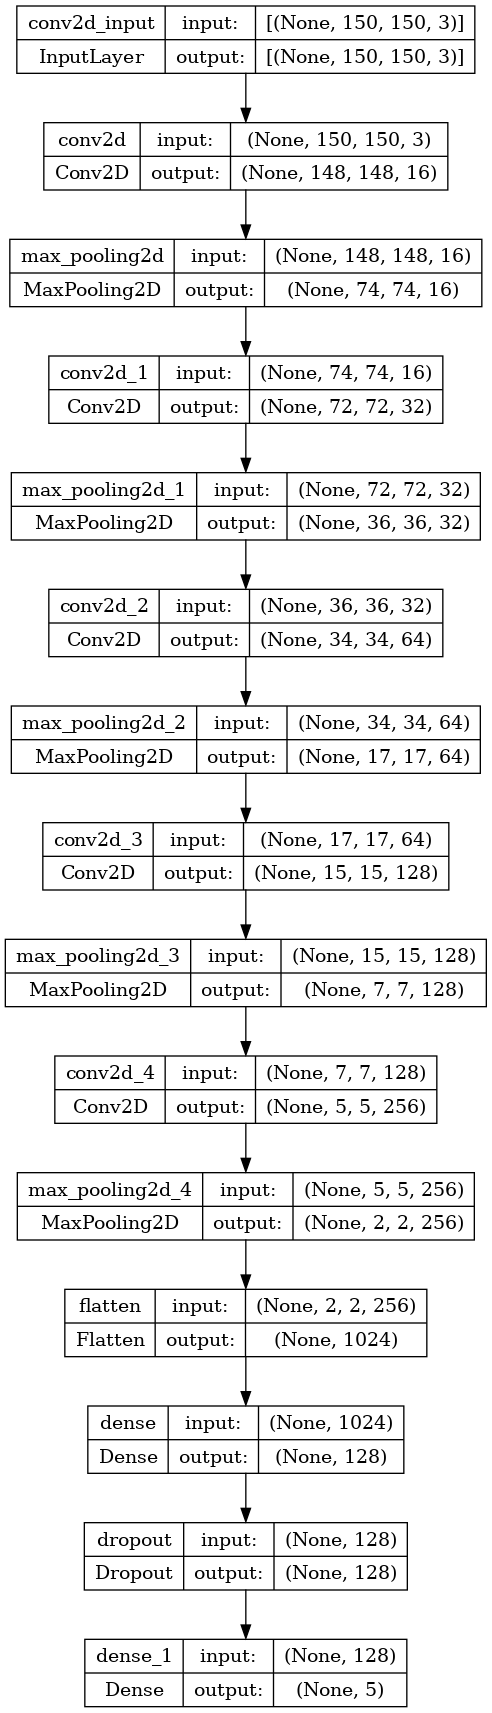

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
# Compile mô hình
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Sử dụng EarlyStopping để dừng quá trình huấn luyện sớm nếu không có cải tiến đáng kể
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [11]:
# Huấn luyện mô hình
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[early_stopping])

Epoch 1/20
313/313 [==============================] - 160s 462ms/step - loss: 1.6111 - accuracy: 0.1952 - val_loss: 1.6095 - val_accuracy: 0.1995
Epoch 2/20
313/313 [==============================] - 110s 353ms/step - loss: 1.6101 - accuracy: 0.2034 - val_loss: 1.6076 - val_accuracy: 0.2252
Epoch 3/20
313/313 [==============================] - 100s 321ms/step - loss: 1.6057 - accuracy: 0.2191 - val_loss: 1.5974 - val_accuracy: 0.2380
Epoch 4/20
313/313 [==============================] - 100s 318ms/step - loss: 1.5945 - accuracy: 0.2451 - val_loss: 1.5748 - val_accuracy: 0.2632
Epoch 5/20
313/313 [==============================] - 100s 319ms/step - loss: 1.5844 - accuracy: 0.2603 - val_loss: 1.5635 - val_accuracy: 0.3181
Epoch 6/20
313/313 [==============================] - 100s 320ms/step - loss: 1.5729 - accuracy: 0.2765 - val_loss: 1.5290 - val_accuracy: 0.3241
Epoch 7/20
313/313 [==============================] - 99s 317ms/step - loss: 1.5525 - accuracy: 0.2957 - val_loss: 1.4949 - 

In [13]:
# Đánh giá độ chính xác của mô hình
score = model.evaluate(train_generator,verbose=0)
print('Sai số kiểm tra là: ',score[0])
print('Độ chính xác kiểm tra là: ',score[1])

Sai số kiểm tra là:  1.220505714416504
Độ chính xác kiểm tra là:  0.5035927891731262


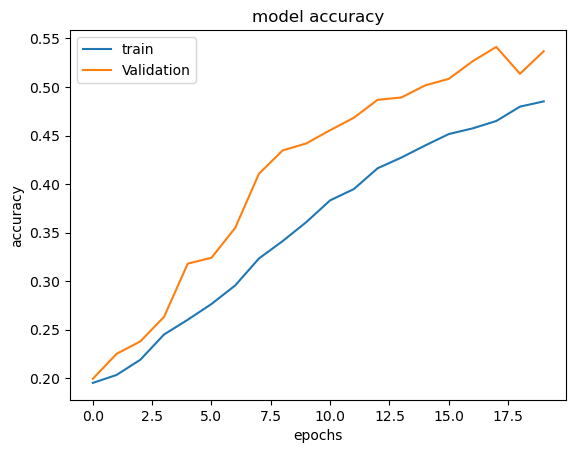

In [16]:
import matplotlib.pyplot as plt
# Draw plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','Validation'])
plt.show()

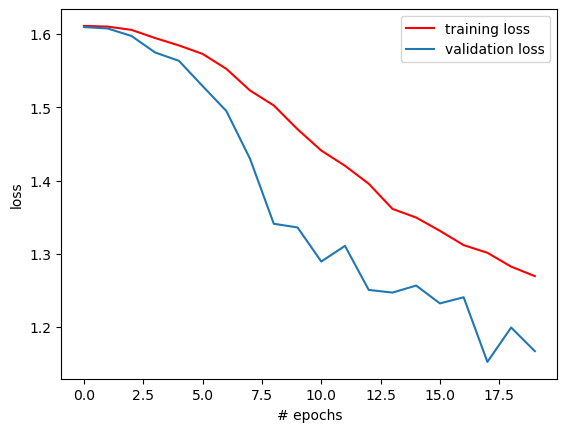

In [17]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [18]:
from tensorflow.keras.models import load_model
model.save('Emotion1.h5')